In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, SubsetRandomSampler

/opt/anaconda3/envs/deeplearningproject2/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/deeplearningproject2/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <367D4265-B20F-34BD-94EB-4F3EE47C385B> /opt/anaconda3/envs/deeplearningproject2/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/deeplearningproject2/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/deeplearningproject2/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/deeplearningproject2/lib/python3.12/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/deeplearningproject2/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this

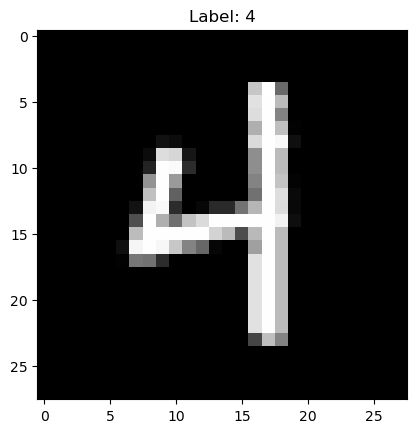

In [4]:
# Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Load MNIST dataset
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)

# Create validation split (10,000 for validation, 50,000 for training)
train_size = 50000
val_size = 10000
indices = list(range(len(train_dataset)))
np.random.shuffle(indices)
train_indices, val_indices = indices[:train_size], indices[train_size:train_size + val_size]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Visualize a sample
images, labels = next(iter(train_loader))
plt.imshow(images[0].numpy().squeeze(), cmap='gray')
plt.title(f'Label: {labels[0].item()}')
plt.show()

In [5]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

# Hyperparameters
input_size = 784  # 28x28 pixels
hidden1_size = 20
hidden2_size = 10
num_classes = 10
model = NeuralNet(input_size, hidden1_size, hidden2_size, num_classes).to(device)

Epoch [1/10], Train Loss: 0.7449, Val Loss: 0.4197
Epoch [2/10], Train Loss: 0.3925, Val Loss: 0.3678
Epoch [3/10], Train Loss: 0.3627, Val Loss: 0.3440
Epoch [4/10], Train Loss: 0.3427, Val Loss: 0.3324
Epoch [5/10], Train Loss: 0.3283, Val Loss: 0.3154
Epoch [6/10], Train Loss: 0.3159, Val Loss: 0.3026
Epoch [7/10], Train Loss: 0.3016, Val Loss: 0.2871
Epoch [8/10], Train Loss: 0.2944, Val Loss: 0.2839
Epoch [9/10], Train Loss: 0.2874, Val Loss: 0.2848
Epoch [10/10], Train Loss: 0.2816, Val Loss: 0.2713


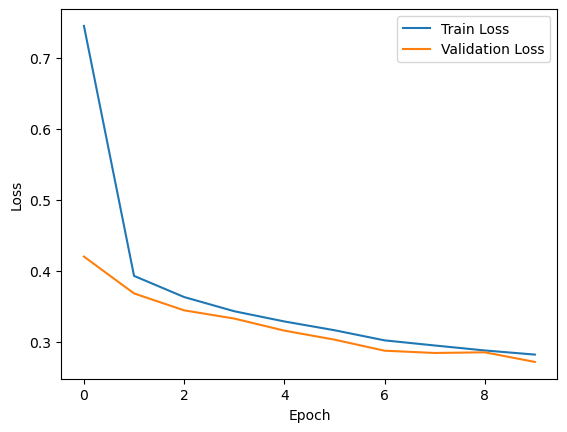

In [6]:
# Loss and optimizer with L2 regularization
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)  # L2 regularization via weight_decay

# Training loop with validation
num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

# Plot losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

# Optional: Simple hyperparameter tuning
learning_rates = [0.001, 0.0001]
for lr in learning_rates:
    model = NeuralNet(input_size, hidden1_size, hidden2_size, num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
    for epoch in range(5):  # Quick test with fewer epochs
        model.train()
        for images, labels in train_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f'Learning Rate {lr}, Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 92.71%
Learning Rate 0.001, Test Accuracy: 92.01%
Learning Rate 0.0001, Test Accuracy: 87.11%
